In [90]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import rcParams

#path = '/kaggle'
path = '/tmp/working'
input_path = path + '/input/gearbox-fault-diagnosis-stdev-of-accelerations/'
broken_dataset  = "b30hz_stdev_100.csv"
healthy_dataset = "h30hz_stdev_100.csv"


## Build healthy/broken dataset

In [91]:
healthyDataset = pd.read_csv(input_path + healthy_dataset)
brokenDataset = pd.read_csv(input_path + broken_dataset)

dataset = pd.concat([healthyDataset, brokenDataset], axis=0)
dataset.describe()

,a1,a2,a3,a4,load,failure
count,20203.000000,20203.000000,20203.000000,20203.000000,20203.000000,20203.000000
mean,5.766842,4.266330,3.847555,4.276706,45.644706,0.497401
std,2.219236,1.162870,1.020591,1.228792,28.660383,0.500006
min,1.468928,1.272738,0.990336,1.111679,0.000000,0.000000
25%,4.164285,3.473209,3.118392,3.409206,20.000000,0.000000
50%,5.337988,4.146414,3.779156,4.211713,50.000000,0.000000
75%,7.003621,4.903647,4.521386,5.078614,70.000000,1.000000
max,23.909199,10.984053,8.273939,10.609798,90.000000,1.000000


# Logistic regression

In [92]:
# Predictor variable (features)
columns = ['a1', 'a2', 'a3', 'a4', 'load']
X = dataset[columns]
# Target variable: Failure (boolean)
#y = dataset.iloc[:,-1]
y = dataset[['failure']]

In [93]:
# Split the dataset: 80% train, 20% test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Logistic regression classifier
from sklearn.linear_model import LogisticRegression

# Setup the model
logis = LogisticRegression(max_iter=1000)

# Train the model
logis_trained = logis.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Predict Failure for the test set

In [94]:
y_pred = logis.predict(X_test)
print("Prediction for the test data (first 10 rows):", y_pred[:10])
#print(X_test.iloc[:10,:])

Prediction for the test data (first 10 rows): [1 0 0 0 1 1 0 1 0 0]


## Computed probabilities for the test set

In [95]:
y_prob = logis_trained.predict_proba(X_test)[:,1]
print("Probability for the test data (first 10 rows): \n", y_prob[:10])

Probability for the test data (first 10 rows): 
 [9.97228103e-01 3.17014019e-07 7.85660710e-05 1.41006715e-01
 9.99768984e-01 9.46742240e-01 3.14668355e-03 9.93853471e-01
 4.97123911e-06 1.94570757e-01]


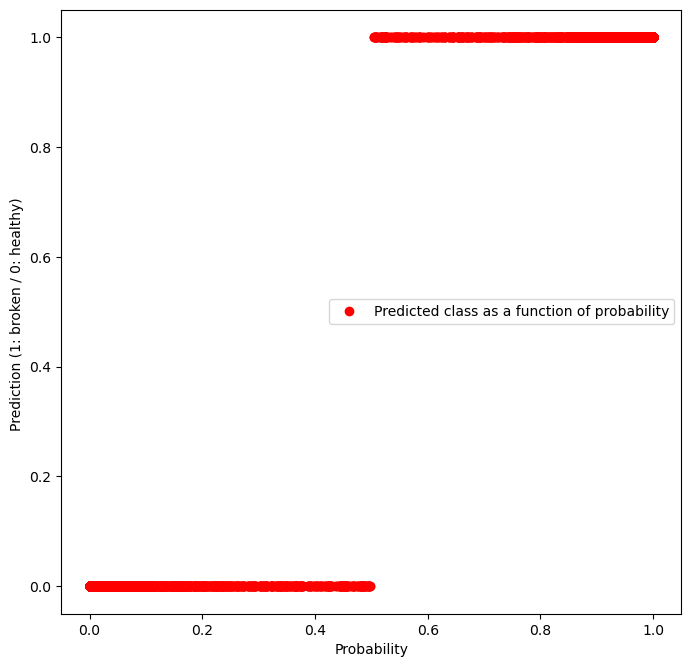

In [96]:
plt.figure(figsize = (8,8), dpi=100)

plt.plot(y_prob, y_pred, 'o', color='red', label = "Predicted class as a function of probability")
#plt.plot(y_pred, y_prob, 'o', color='black');

plt.xlabel('Probability')
plt.ylabel('Prediction (1: broken / 0: healthy) ')

plt.legend()

plt.show()

In [97]:
y_test.iloc[:,0]

9580    1
772     0
1884    0
7292    1
6029    1
       ..
7280    0
7362    0
1748    0
2952    0
9862    0
Name: failure, Length: 4041, dtype: int64

## Confusion matrix

In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred,y_test)
cm

array([[1851,  194],
       [ 167, 1829]])

In [99]:
# .score returns the mean accuracy on the given test data and labels
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
print( logis.score(X_test,y_test) , logis.score(X_train,y_train) )

0.9106656768126701 0.915542630862517


## Classification report

In [100]:
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2018
           1       0.92      0.90      0.91      2023

    accuracy                           0.91      4041
   macro avg       0.91      0.91      0.91      4041
weighted avg       0.91      0.91      0.91      4041



## ROC curve

In [101]:
# For the ROC curve we need not only the predicted class ('Outcome'), but also the scores on what the predictions are based
# * if threshold 0
#  ** predict>0 => Outcome=1
#  ** predict<0 => Outcome=0 
#  - Remember that predictions were calculated with METHOD .predict(X_test)
#  - Now we also have to include METHOD .decision_function(X_test)
y_pred_score = logis.decision_function(X_test)

In [102]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

# If using the test set (X_test, y_test)
fpr,tpr,threshold= roc_curve(y_test, y_pred_score)

In [103]:
# Area Under Curve
lr_auc = auc(fpr, tpr)
print("AUC=", lr_auc)

AUC= 0.972162303970151


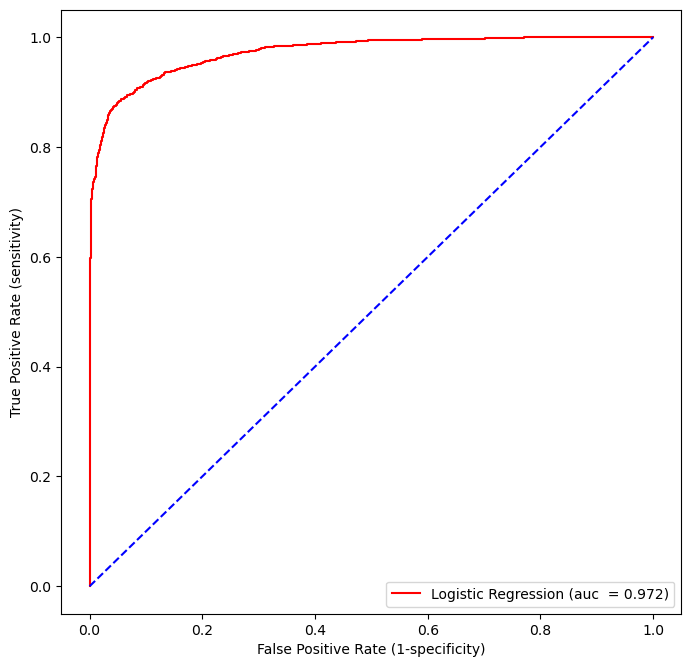

In [104]:
# This default size comes from above
#rcParams['figure.figsize'] = 12, 8

plt.figure(figsize = (8,8), dpi=100)

plt.plot(fpr, tpr, color='red', linestyle='-', label = "Logistic Regression (auc  = %0.3f)"%lr_auc)
plt.plot([0,1],[0,1],color='blue',linestyle='--')

plt.xlabel('False Positive Rate (1-specificity)')
plt.ylabel('True Positive Rate (sensitivity)')

plt.legend()

plt.show()